# Training with CatBoostClassifier


**In this notebook:**
* training CatBoostClassifier
* test model on test data set
* save prediction in Kaggle submission format

**Key insights:**
* reaching logloss of 2.05 
* test accuracy is low

## Installations

In [ ]:
!pip install catboost

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN

sys.path.append("../utils/")

from evaluation import Evaluation

Using TensorFlow backend.


## Load Data

In [2]:
data_path = "../../data/msk-redefining-cancer-treatment"
x_train = np.load(os.path.join(data_path, "processed/x_train_shuffled.npy"))
y_train = np.load(os.path.join(data_path, "processed/y_train_shuffled.npy"))
x_test = np.load(os.path.join(data_path, "processed/x_test_shuffled.npy"))
y_test = np.load(os.path.join(data_path, "processed/y_test_shuffled.npy"))
print("Training Data Shape:".ljust(20), x_train.shape)
print("Test Data Shape:".ljust(20), x_test.shape)

Training Data Shape: (3683, 111)
Test Data Shape:     (125, 111)


## Prepare Data

Training Data Shape after Oversampling: (9447, 111)


<BarContainer object of 9 artists>

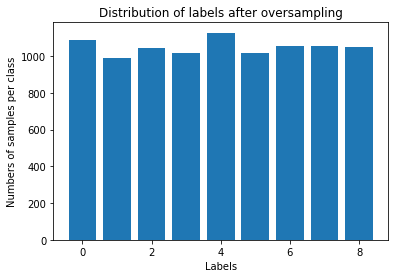

In [3]:
# Oversampling
x_train, y_train = ADASYN(sampling_strategy="auto").fit_sample(x_train, y_train)
print("Training Data Shape after Oversampling:", x_train.shape)
plt.title("Distribution of labels after oversampling")
plt.xlabel("Labels")
plt.ylabel("Numbers of samples per class")
plt.bar(
    np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1]
)

In [4]:
# new labels 0,1,...8
y_train = y_train - 1
y_test = y_test - 1 

## Training Models

In [5]:
# initialize model
model = CatBoostClassifier(
    iterations=250,
    learning_rate=0.01,
    depth=4,
    l2_leaf_reg=3,
    model_size_reg=10,
    rsm=None,
    loss_function="MultiClass", # Negative Log Likelihood Loss 
    random_seed=100,
    classes_count=9,
    verbose=False,
    bagging_temperature=1.0,
    boosting_type="Plain",  # Ordered — Usually provides better quality on small datasets, but it may be slower than the Plain scheme. Plain — The classic gradient boosting scheme.
    max_bin=255,
)

In [7]:
modeltime = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")

# train the model
model.fit(x_train, y_train, verbose_eval=0)

CatBoostError: catboost/private/libs/target/target_converter.cpp:166: Value in target (-1) is not expected class index

In [ ]:
model.get_evals_result()

In [ ]:
modeltime

In [ ]:
model.save_model("models/catboost_" + "modeltime_" + modeltime)

In [ ]:
# make the prediction using the resulting model
preds_class = model.predict(x_test)
preds_proba = model.predict_proba(x_test)
print("proba = ", preds_proba)

In [ ]:
# Transform into submission format
submission = pd.DataFrame(preds_proba, columns=["class" + str(c + 1) for c in range(9)])
submission["ID"] = np.arange(1, 987)
# Save submission without weighting
submission.to_csv("submissions/submission_catboost_" + modeltime + ".csv", index=False)

## Weighting Predictions

In [ ]:
all_1_over_9 = pd.read_csv(os.path.join(data_path, "external/submission_1_over_9.csv"))
all_1_over_9 = all_1_over_9.drop("ID", axis=1)

# weighted average
weighting = (6, 4)
submission_weighted = (preds_proba * weighting[0] + all_1_over_9 * weighting[1]) / 10
submission_weighted.shape

## Private Leaderboard Evaluation

In [ ]:
ids = pd.read_csv(os.path.join(data_path, "raw/stage_2_private_solution.csv")).ID.values
pred = np.take(submission_weighted, (list(ids - 1)), axis=0)
pred

In [ ]:
ev = Evaluation(y_pred=pred.to_numpy(), y_test=y_test)
ev.entire_evaluation(filename="results_catboost.csv")

## Save Submission

In [ ]:
# transform weighted average into kaggle format
submission_weighted = pd.DataFrame(
    submission_weighted, columns=["class" + str(c + 1) for c in range(9)]
)
submission_weighted["ID"] = np.arange(1, 987)

# save submission
submission_weighted.to_csv(
    "submissions/submission_catboost_weighted"
    + str(weighting)
    + "_"
    + modeltime
    + ".csv",
    index=False,
)